# Swin Unet実装

In [35]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from einops import rearrange
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import cv2
import matplotlib.pyplot as plt
import numpy as np


In [8]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super(Mlp, self).__init__()
        hidden_features = hidden_features or in_features
        out_features = out_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [22]:
def window_partition(x, window_size):
    """
    Args:
        x:(B, H, W, C)
        window_size (int): window size
    
    Return:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H//window_size,window_size, W//window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H*W/window_size/window_size))
    x = windows.view(B, H//window_size,window_size,W//window_size,window_size, -1)
    x = x.permute(0,1,3,2,4,5).contiguous().view(B, H, W, -1)
    return x


In [24]:
x = torch.rand(size=(16, 256, 256, 3))
windows = window_partition(x, 32)
window_reverse(windows,32,256, 256).shape

torch.Size([16, 256, 256, 3])

In [30]:
image = cv2.imread("../dataset/cat.jpg")
image = cv2.resize(image, (256,256))
image = torch.tensor(image, dtype=torch.float32).view(1, *image.shape)

In [36]:
def tensor2array(x):
    x = x.squeeze().detach().numpy().astype(np.uint8)
    return x

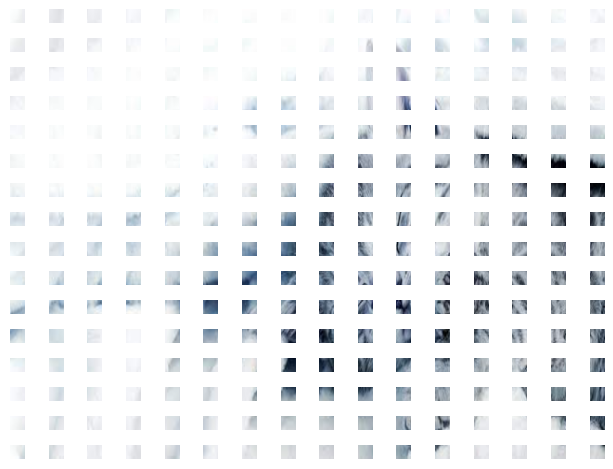

In [66]:
p = 4 
windows = window_partition(image, 2**p)
def plot(x):
    plt.imshow(tensor2array(x))

s = int((256//2**p))
for i in range(1,s**2+1):
    plt.subplot(s,s,i)
    plot(windows[i-1])
    plt.axis("off")
plt.tight_layout()
plt.show()

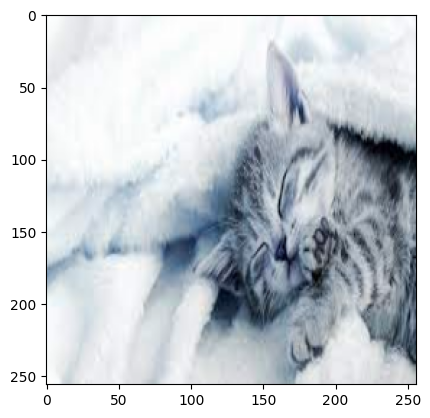

In [68]:
rev_x = window_reverse(windows, 2**p, 256,256)
plot(rev_x)

In [54]:
2**6

64